sigmaB              0.01   0.05   0.10   0.20   0.30   0.50    0.60
multiplier sigmaY                                                  
5          0.01    74.34  74.41  74.78  76.28  81.71  97.33  106.54
           0.05    73.77  73.69  73.47  75.92  81.37  95.57  106.40
           0.10    72.81  72.86  72.86  75.26  80.42  97.48  104.57
           0.20    70.72  70.59  70.63  72.70  77.88  93.56  103.21
           0.30    68.58  68.73  68.88  69.74  77.06  91.97   99.14
           0.50    64.45  64.81  64.89  66.98  72.34  87.83   97.67

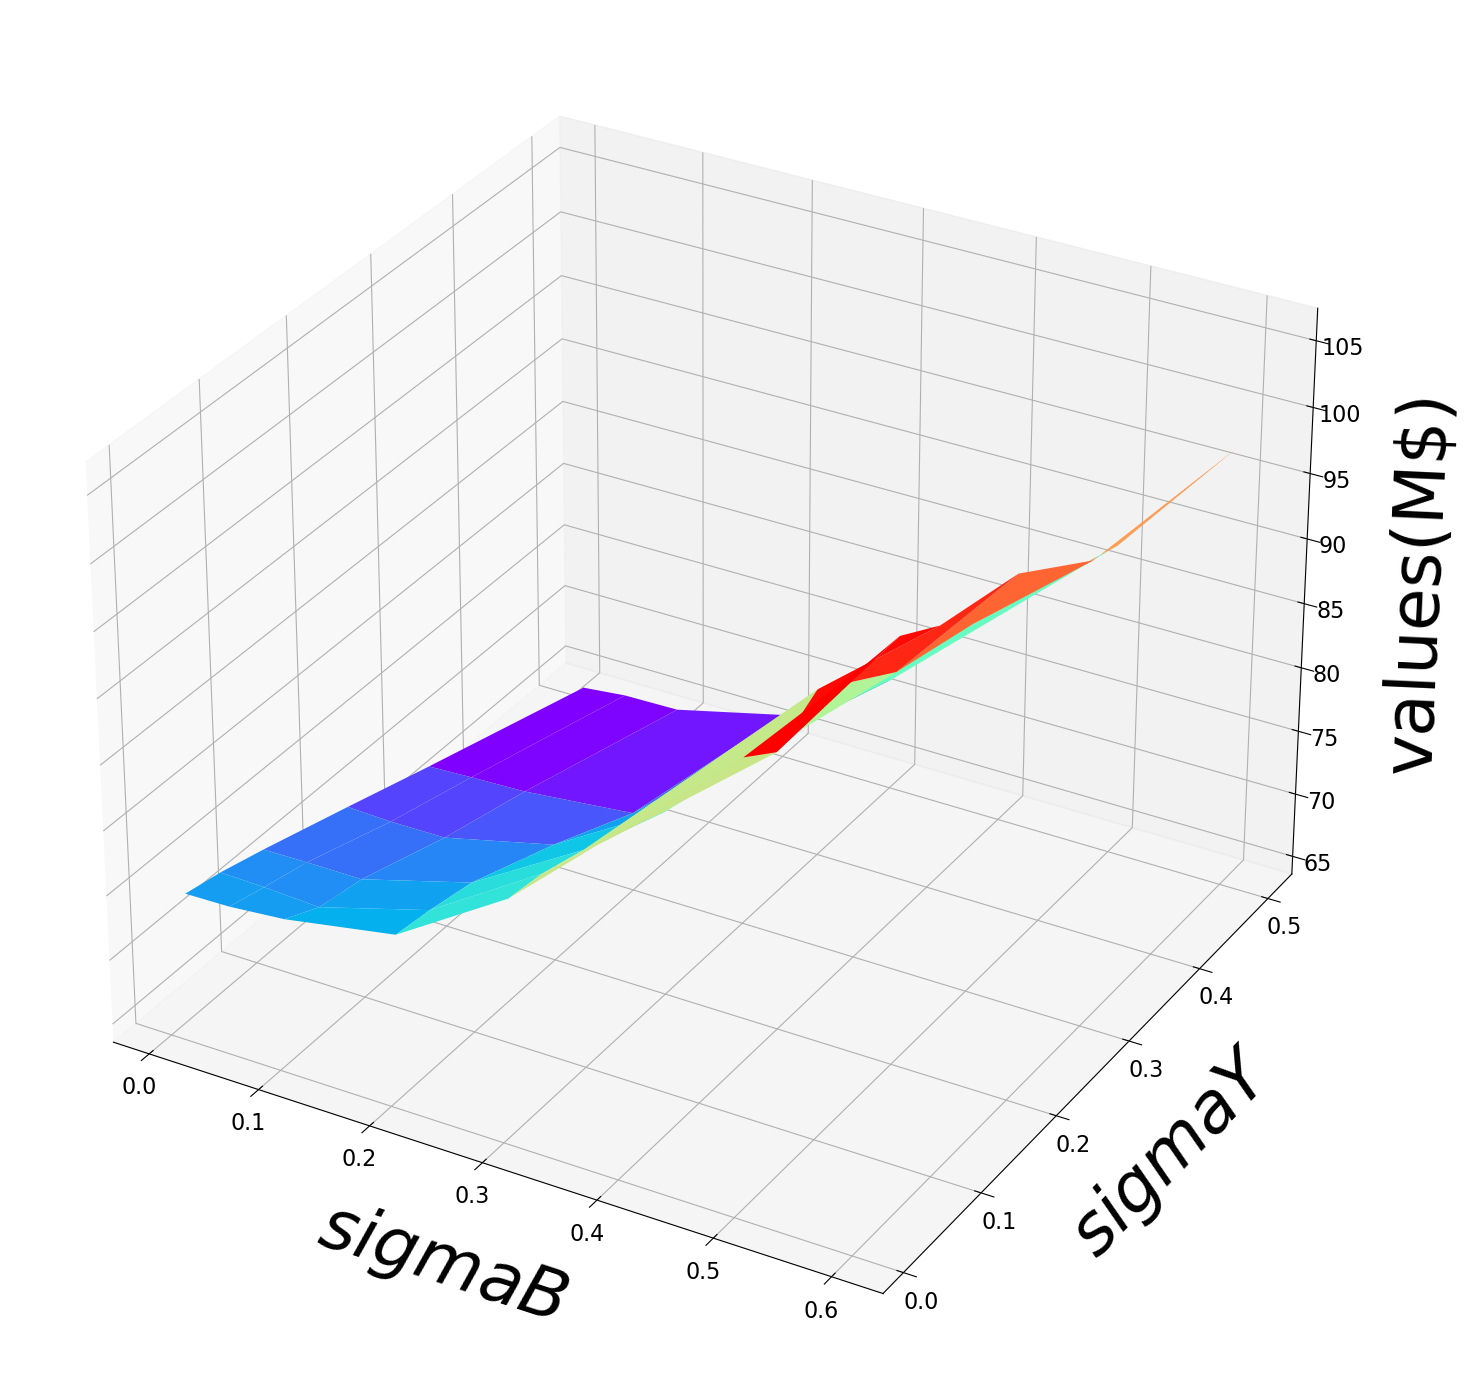

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

def ST_cal (S0, r_d, r_f, sigma, T, rho, epsilon):
    
    return 1 / (1 / S0 * np.exp((r_d - r_f - (sigma**2/2)) * T + sigma * epsilon * np.sqrt(T)))
    
def alpha_cal (YT, Y0, BT, B0, multiplier=5):

    return max(0, (YT-Y0)/YT) + min(1, multiplier * (B0-BT)/BT)

def payment_cal (alpha):

    return 53 * (1 - 0.03 - alpha)

def yen_baht_simulation (Y0, B0, r_domestic, r_yen, r_baht, T, rho, sigma_yen, sigma_baht, N=1000):
    
    epsilon_1 = np.random.standard_normal(N)
    epsilon_2 = rho * epsilon_1 + np.random.standard_normal(N)*np.sqrt((1-rho**2))

    YT = ST_cal(Y0, r_domestic, r_yen, sigma_yen, T, rho, epsilon_1)
    BT = ST_cal(B0, r_domestic, r_baht, sigma_baht, T, rho, epsilon_2)

    payment = np.array([])

    for zip_T in zip(YT, BT):
        payment = np.append(payment, payment_cal(alpha_cal(zip_T[0], Y0, zip_T[1], B0)))

    return round(payment.mean() * np.exp(-r_domestic * T), 2)

r_domestic = 0.03
r_yen = 0.01
r_baht = 0.13
Y0 = 122
B0 = 25.884
T = 1
rho = 0.2

sigma_baht_list = [0.01, 0.05, 0.10, 0.20, 0.30, 0.50, 0.60]
sigma_yen_list = [0.01, 0.05, 0.10, 0.20, 0.30, 0.50]

result_df = pd.DataFrame(index=[[5 for x in sigma_yen_list], sigma_yen_list], columns=sigma_baht_list)
result_df.index = pd.MultiIndex.from_tuples(result_df.index, names=('multiplier', 'sigmaY'))
result_df.columns.names = ['sigmaB']

for sigma_baht in sigma_baht_list:
    values = []

    for sigma_yen in sigma_yen_list:
        value = yen_baht_simulation(Y0, B0, r_domestic, r_yen, r_baht, T, rho=rho, sigma_yen=sigma_yen, sigma_baht=sigma_baht, N=10000)
        values.append(value)

    result_df[sigma_baht] = values
        
display(result_df)

fig = plt.figure(figsize=(14,14), facecolor='w')
ax = fig.add_subplot(111, projection='3d')

sigmaB, sigmaY = np.meshgrid(result_df.columns.to_list(), result_df.index.get_loc_level(5)[1].to_list())
ax.plot_surface(sigmaB, sigmaY, result_df, cmap='rainbow')

ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)

ax.set_xlabel('$sigmaB$', size=50, labelpad=30)
ax.set_ylabel('$sigmaY$', size=50, labelpad=30)
ax.set_zlabel('values(M$)', size=50, labelpad=30)

plt.tight_layout()
plt.show()